In [5]:
%matplotlib inline
from dateutil.parser import parse
import gzip
import json
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

In [2]:
inputfile="/Users/nikhil/phd/urban_computing/datasets/wmata/wmata_2015_2016/user_timeseries_sorted_10000.gz"

In [6]:
#We expect event_list to be a series object of value_counts.
def _perturb(event_list,_e=1.667e-4):
    events=list()
    for t, cnt in event_list.iteritems():
        base_time = t
        for i in range(cnt):
            #here we just add i*e_i (a very small perturbation) to avoid collisions.
            events.append(base_time + (_e*i))  
    return events

def read_data_wmata(inputfile,scaletimeunit='D',precision=4,_e=1.667e-6,num_users=5000,test_percentage=0.2):
    with gzip.open(inputfile) as f:
        cnt = 0
        user_events_train = list()
        user_events_test=list()
        user_ids= list()
        empirical_counts=list()
        for idx,line in enumerate(f):
            if (idx%1000)==0:
                print(idx)
            if idx >= num_users:
                break

            _user_events=list()
            _tmp=json.loads(line.decode('utf-8'))
            _user_events=pd.Series(sorted([parse(_dt) for _dt in _tmp['arrivalTimes']]))
                        
            user_ids.append(_tmp['_id'])
            _user_events=((_user_events - _user_events[0]).apply(lambda x:
                        round(x/np.timedelta64(1, scaletimeunit),precision))
                          .value_counts().sort_index())
            all_user_events=_perturb(_user_events)
            train_end_idx=len(all_user_events) - int(len(all_user_events)*test_percentage)
            #print(train_end_idx,len(all_user_events))
            test_user_events=all_user_events[train_end_idx+1:]
            train_user_events=all_user_events[:train_end_idx]
            user_events_train.append(train_user_events)
            user_events_test.append(test_user_events)
            empirical=pd.Series(sorted([parse(_dt) for _dt in _tmp['arrivalTimes']]))
            emp_cnt_val=empirical.value_counts().resample(rule=scaletimeunit).sum().fillna(0)
            empirical_counts.append(emp_cnt_val)
            
    user_events_train=pd.DataFrame(user_events_train)
    mask_train = ~(user_events_train.isnull()).as_matrix()
    user_events_test=pd.DataFrame(user_events_test)
    mask_test = ~(user_events_test.isnull()).as_matrix()
    
    return np.nan_to_num(user_events_train.as_matrix()),np.nan_to_num(user_events_test.as_matrix()),mask_train,mask_test,empirical_counts,user_ids


In [7]:
events_train,events_test,mask_train,mask_test,empirical_counts,user_ids=read_data_wmata(inputfile,test_percentage=0.2)

0
1000
2000
3000
4000
5000


<h2> Autoregression </h2>

In [8]:
df= pd.concat(empirical_counts, axis=1).fillna(0)

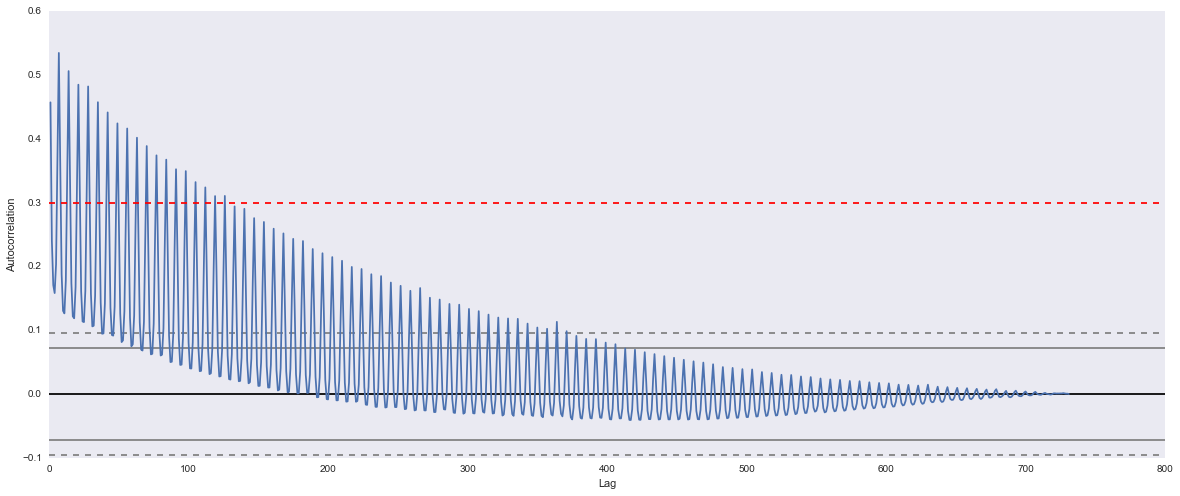

In [9]:
#Plot Autocorrelation and show how previous day patterns are correlated.
#Link: https://people.maths.bris.ac.uk/~magpn/Research/LSTS/STSIntro.html
#About 125 days there is a 0.3 positive correlation for 5000 users.
fig,ax=plt.subplots(1,1,figsize=(20,8))
autocorrelation_plot(df,ax=ax)
ax.axhline(y=0.3,color='r',linestyle='--')

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

In [11]:
df.mean().shape

(5000,)

In [12]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0
2015-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df.head(3).diff()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0
2015-01-03,1.0,0.0,0.0,0.0,0.0,0.0,-3.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-2.0,-2.0


(-0.1, 0.1)

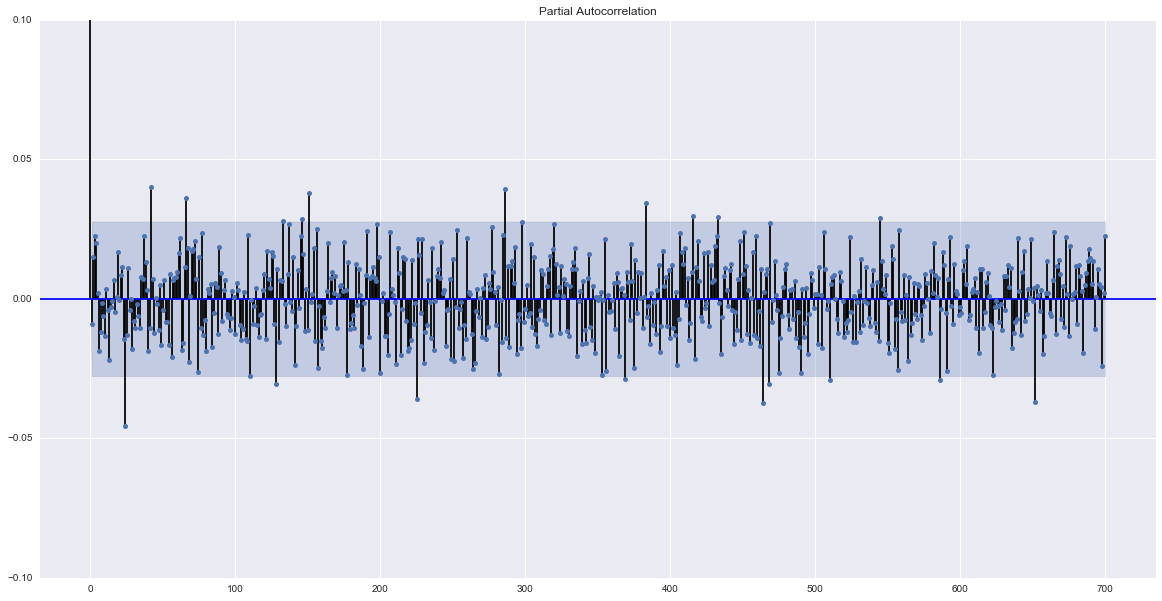

In [14]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
plot_pacf(df.fillna(0).sum(),lags=700,ax=ax)
plt.ylim(-0.1,0.1)

In [15]:
#Motivation for why we need conditional intensity.
# for idx,user in enumerate(empirical_counts):
#     fig,ax=plt.subplots(1,1,figsize=(30,3))
#     user.fillna(0).plot(ax=ax,fontsize=20)
#     plt.savefig("/Users/nikhil/phd/Spring_2017/Data_Analysis_II/semester_project/figures/"+str(idx)+".pdf",dpi=600)

In [16]:
empirical_counts[0].head()

2015-01-03    1.0
2015-01-04    0.0
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
Freq: D, dtype: float64

# AR 

# MA

# ARMA


In [17]:
#Follow https://bicorner.com/2015/11/16/time-series-analysis-using-ipython/
# https://coolstatsblog.com/2013/08/07/how-to-use-the-autocorreation-function-acf/

#Auto-correlation
#Partial Autocorrelation
#ARMA Model P parameter Residual
#MSE with varying P parameter.
#Dublin_Watson Statistic.
#Plot the QQ Plot

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

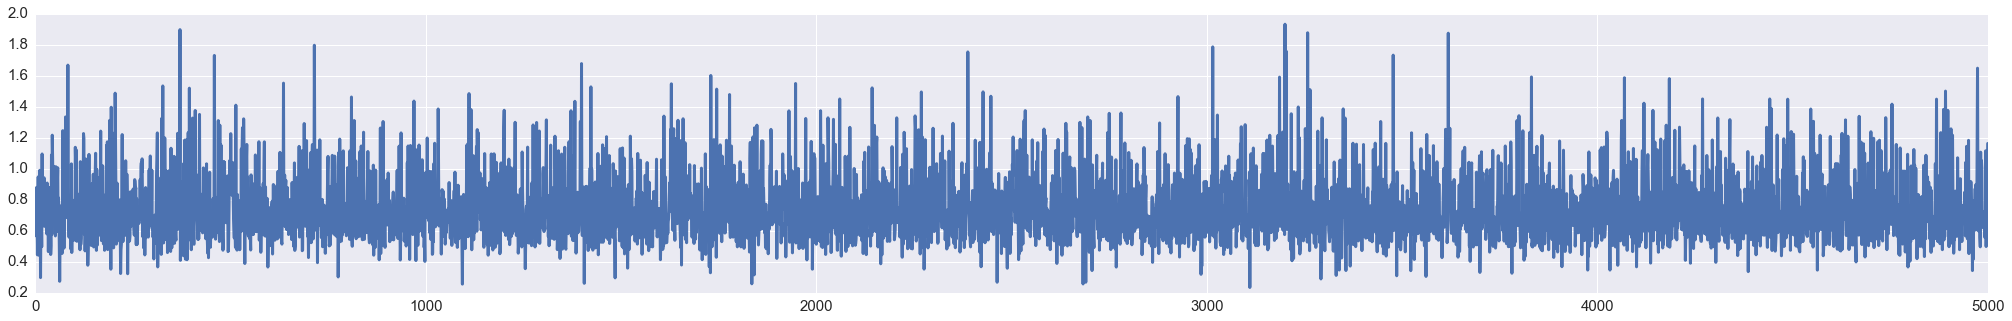

In [18]:
fig,ax=plt.subplots(1,1,figsize=(35,5))
ax.plot(sm.stats.durbin_watson(df),linewidth=3)
ax.set_xticklabels(map(lambda x: int(x),ax.get_xticks()),fontsize=15)
ax.set_yticklabels(ax.get_yticks(),fontsize=15)
#This number as it is below 2 indicates strong autocorrelation according to the dublin-watson test.
fig.savefig("/Users/nikhil/phd/Spring_2017/Data_Analysis_II/semester_project/figures/dublin_watson_stat_5000.pdf",dpi=600)

In [24]:
def _ar(data):
    model=sm.tsa.AR(data)
    model_fit= model.fit()
    #print("Lag: %s "% model_fit.k_ar)
    return model_fit.k_ar

def test_ar(data,train_percentage=0.5,p=2,q=0):
    predictions=list()
    num_rows=data.shape[0]
    train_end_idx=int(num_rows*train_percentage)
    durbin_watson_value=list()
    while train_end_idx<num_rows:
        train_data=data[:train_end_idx]
        model_fit = sm.tsa.ARMA(train_data, (p,q)).fit(disp=0)
        output = model_fit.forecast()  #Outputs next value.
        yhat = output[0]
        predictions.append(yhat)
        obs = data[train_end_idx]  #Check the current observation.
        train_end_idx+=1
        if (train_end_idx%10)==0:
            print('predicted=%f, expected=%f' % (yhat, obs),"train_end_idx",train_end_idx,"total data",num_rows)
    durbin_watson_val=sm.stats.durbin_watson(data[int(num_rows*train_percentage):] - predictions)
    print("Durbin Watson Value",durbin_watson_val)
    durbin_watson_value.append(durbin_watson_val)
    error = mean_squared_error(data[int(num_rows*train_percentage):], predictions)
    print('Test MSE: %.3f' % error)
    # plot
    fig,ax=plt.subplots(1,1,figsize=(20,5))
    ax.plot(data[int(num_rows*train_percentage):].values,color='blue')
    ax.plot(predictions, color='red')
    ax.legend(['Daily Checkin counts','Daily Checkin Predictions'])
    return (error,p,q,durbin_watson_value)
    #pyplot.show()
        

def train_ar(p,q,train_data):
    fig,ax=plt.subplots(1,1,figsize=(20,5))
    #fit model
    arma_mod = sm.tsa.ARMA(train_data, (p,q)).fit(disp=0) #This supresses the debug info.
    print("Model Fit Summary",arma_mod.summary())
    #print("AIC,BIC,HQIC",arma_mod.aic,arma_mod.bic,arma_mod.hqic)
    durbin_watson_val=sm.stats.durbin_watson(arma_mod20.resid.values)
    print("Durbin Watson Value",durbin_watson_val)
    resid = arma_mod.resid
    ax.plot(resid)
    
    ax.set_title("Residuals Plot",fontsize=20)
    fig,ax=plt.subplots(1,1,figsize=(6,5))
    resid.plot(kind='kde',ax=ax)
    ax.set_title("Kernel Density Estimate Plot",fontsize=20)
    
    #Residual Describe
    print("\n\n\t\t\t\tResiduals\n"+str("".join(['=']*80))+"\n",resid.describe())
    #Residual Test
    normresult=stats.normaltest(resid)
    #QQ Plot
    fig,ax= plt.subplots(1,1,figsize=(12,8))
    fig = qqplot(resid20, line='q', ax=ax, fit=True)
    

0
1000
2000
3000
4000


(0, 10)

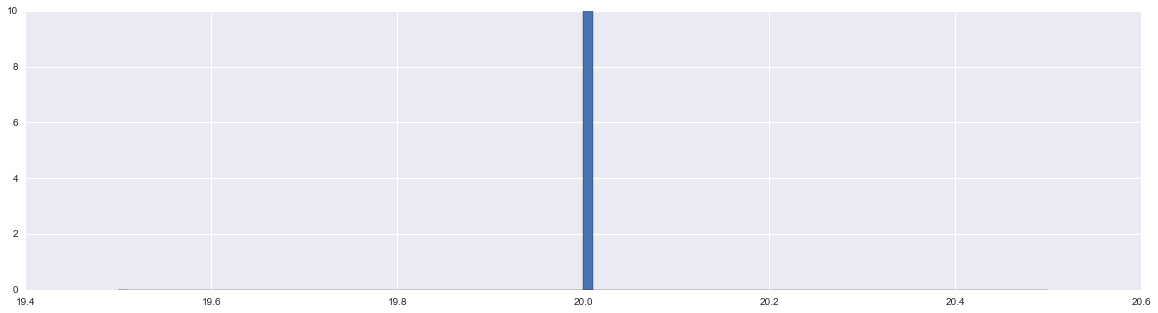

In [22]:
lags=list()
for u in df.columns:
    if u%1000==0:
        print(u)
    lags.append(_ar(df[u].values))
fig,ax=plt.subplots(1,1,figsize=(20,5))
_=ax.hist(lags,bins=100)
ax.set_ylim(0,10)

predicted=0.729683, expected=0.000000 train_end_idx 660 total data 731
predicted=0.376949, expected=0.000000 train_end_idx 670 total data 731
predicted=0.374392, expected=0.000000 train_end_idx 680 total data 731
predicted=0.370435, expected=0.000000 train_end_idx 690 total data 731
predicted=0.726012, expected=1.000000 train_end_idx 700 total data 731
predicted=1.087720, expected=0.000000 train_end_idx 710 total data 731
predicted=0.371674, expected=0.000000 train_end_idx 720 total data 731
predicted=0.363513, expected=0.000000 train_end_idx 730 total data 731
Test MSE: 0.345
user =  0 p =  1 mse =  0.344600918698
predicted=0.729389, expected=0.000000 train_end_idx 660 total data 731
predicted=0.370777, expected=0.000000 train_end_idx 670 total data 731
predicted=0.373525, expected=0.000000 train_end_idx 680 total data 731
predicted=0.370270, expected=0.000000 train_end_idx 690 total data 731
predicted=0.720653, expected=1.000000 train_end_idx 700 total data 731
predicted=1.082567, ex

/Users/nikhil/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.308216, expected=0.000000 train_end_idx 690 total data 731
predicted=0.300181, expected=0.000000 train_end_idx 700 total data 731
predicted=0.292555, expected=0.000000 train_end_idx 710 total data 731
predicted=0.285308, expected=0.000000 train_end_idx 720 total data 731
predicted=0.278412, expected=0.000000 train_end_idx 730 total data 731
Test MSE: 0.094
user =  2 p =  3 mse =  0.0936476497359
predicted=0.251547, expected=0.000000 train_end_idx 660 total data 731
predicted=0.243273, expected=0.000000 train_end_idx 670 total data 731
predicted=0.235528, expected=0.000000 train_end_idx 680 total data 731
predicted=0.228265, expected=0.000000 train_end_idx 690 total data 731
predicted=0.221439, expected=0.000000 train_end_idx 700 total data 731
predicted=0.215011, expected=0.000000 train_end_idx 710 total data 731
predicted=0.208949, expected=0.000000 train_end_idx 720 total data 731
predicted=0.203221, expected=0.000000 train_end_idx 730 total data 731
Test MSE: 0.051
user 

/Users/nikhil/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


predicted=1.957828, expected=2.000000 train_end_idx 660 total data 731
predicted=0.838861, expected=2.000000 train_end_idx 670 total data 731
predicted=1.465028, expected=2.000000 train_end_idx 680 total data 731
predicted=0.061251, expected=0.000000 train_end_idx 690 total data 731
predicted=1.553820, expected=2.000000 train_end_idx 700 total data 731
predicted=0.790695, expected=0.000000 train_end_idx 710 total data 731
predicted=0.928976, expected=2.000000 train_end_idx 720 total data 731
predicted=1.481773, expected=2.000000 train_end_idx 730 total data 731
Test MSE: 0.640
user =  3 p =  5 mse =  0.640433356749
predicted=1.927958, expected=2.000000 train_end_idx 660 total data 731
predicted=1.157575, expected=2.000000 train_end_idx 670 total data 731
predicted=1.747976, expected=2.000000 train_end_idx 680 total data 731
predicted=0.117074, expected=0.000000 train_end_idx 690 total data 731
predicted=1.063269, expected=2.000000 train_end_idx 700 total data 731
predicted=0.638320, ex

/Users/nikhil/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.307759, expected=0.000000 train_end_idx 680 total data 731
predicted=0.290386, expected=0.000000 train_end_idx 690 total data 731
predicted=0.274893, expected=0.000000 train_end_idx 700 total data 731
predicted=0.260989, expected=0.000000 train_end_idx 710 total data 731
predicted=0.248442, expected=0.000000 train_end_idx 720 total data 731
predicted=0.237061, expected=0.000000 train_end_idx 730 total data 731
Test MSE: 0.084
user =  7 p =  9 mse =  0.0837000101928
predicted=0.222445, expected=0.000000 train_end_idx 660 total data 731
predicted=0.218327, expected=0.000000 train_end_idx 670 total data 731
predicted=0.214358, expected=0.000000 train_end_idx 680 total data 731
predicted=0.210531, expected=0.000000 train_end_idx 690 total data 731
predicted=0.206839, expected=0.000000 train_end_idx 700 total data 731
predicted=0.203273, expected=0.000000 train_end_idx 710 total data 731
predicted=0.199829, expected=0.000000 train_end_idx 720 total data 731
predicted=0.196500, e

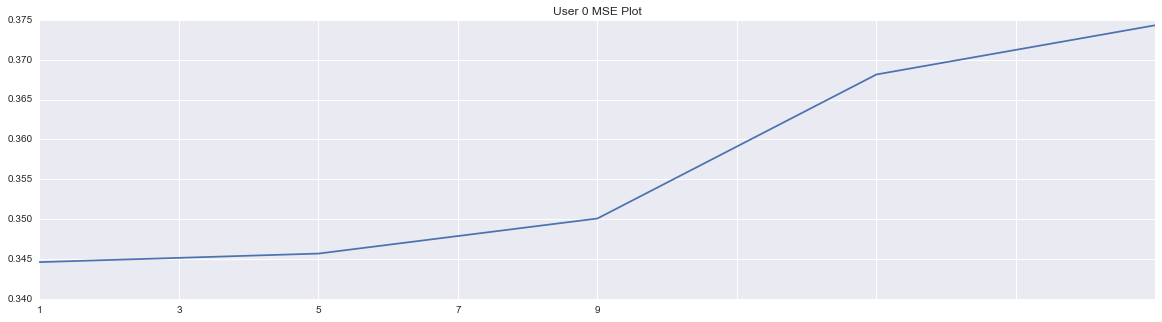

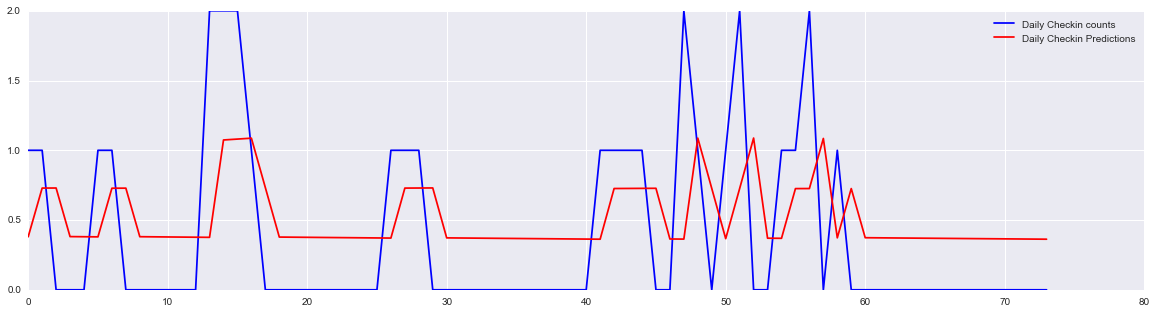

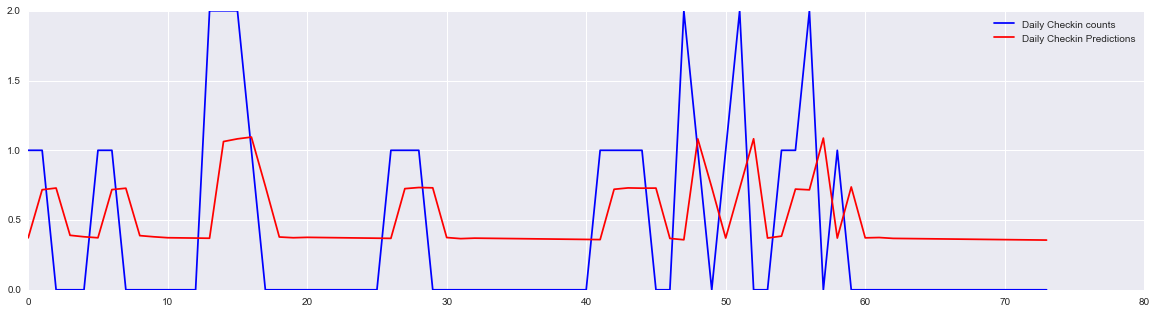

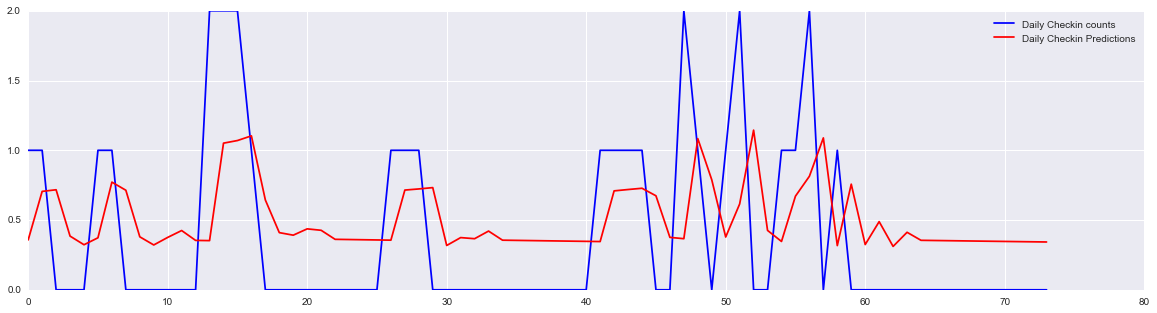

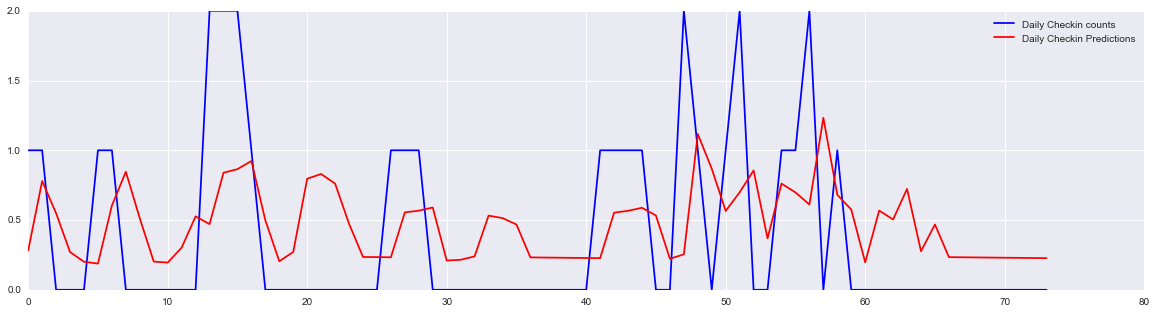

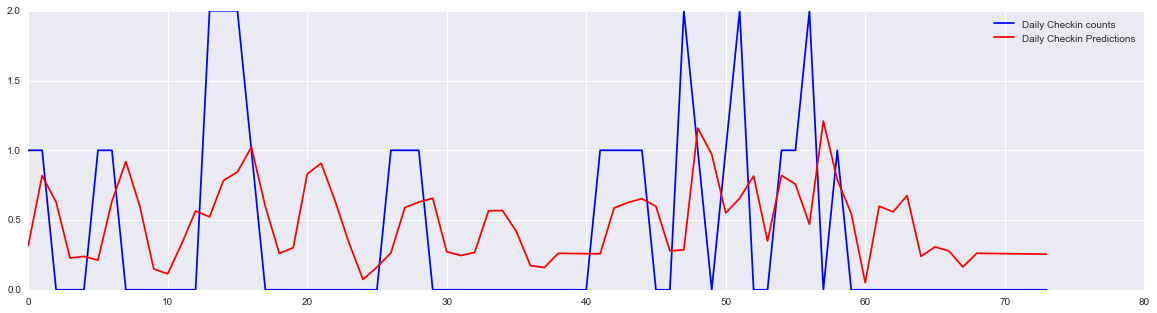

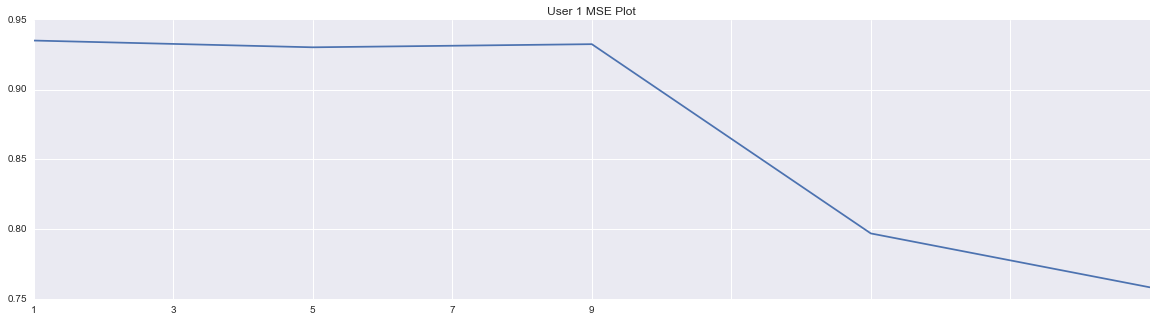

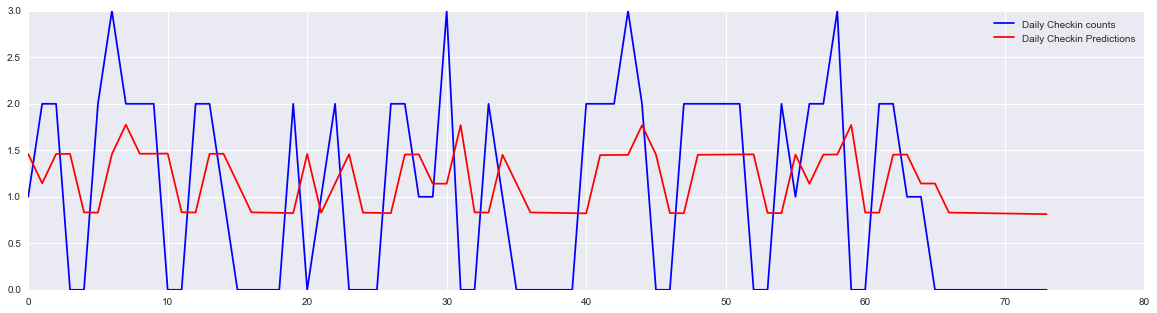

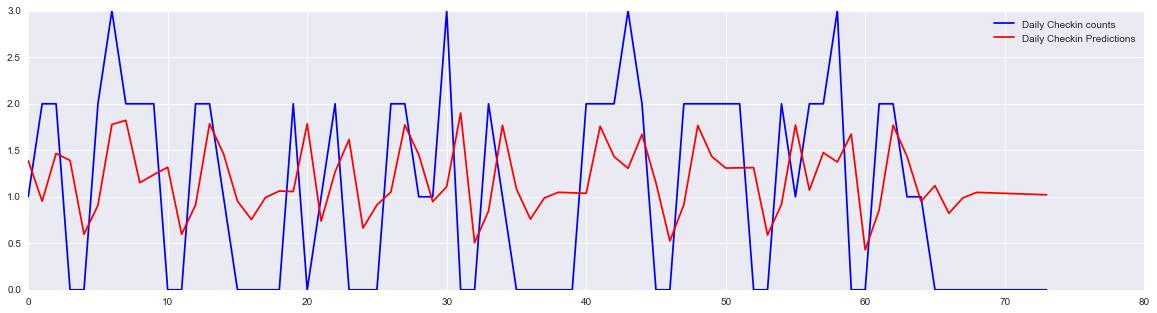

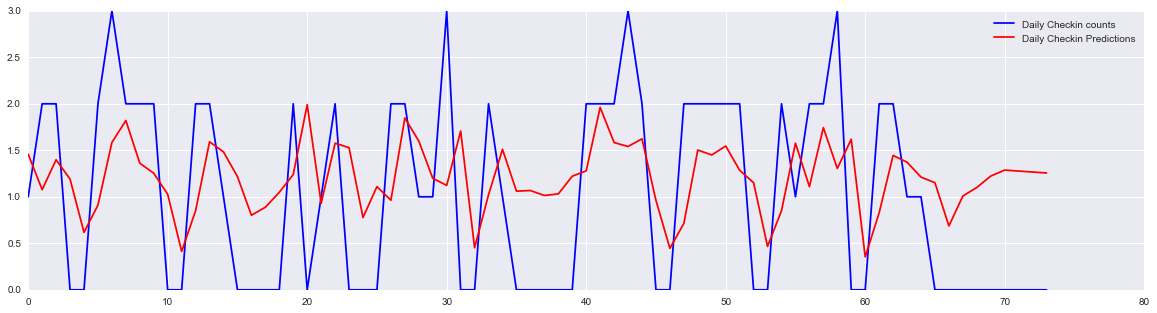

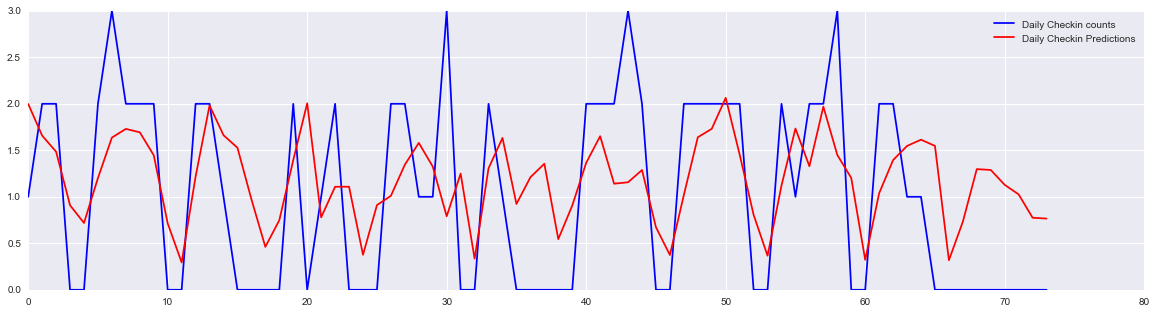

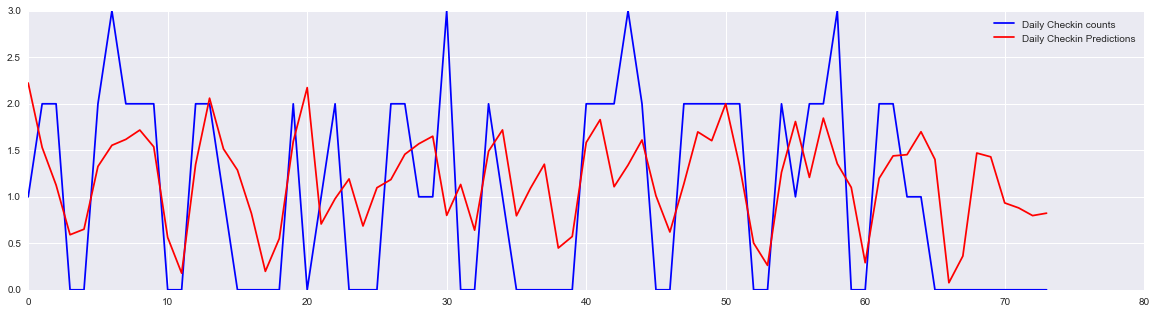

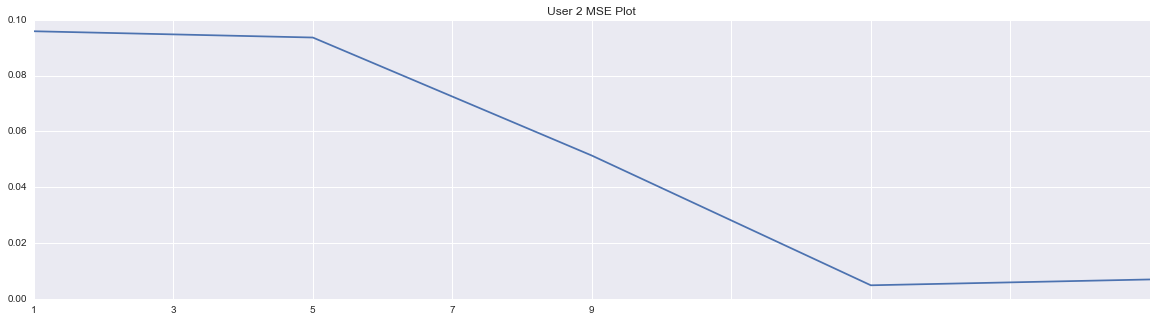

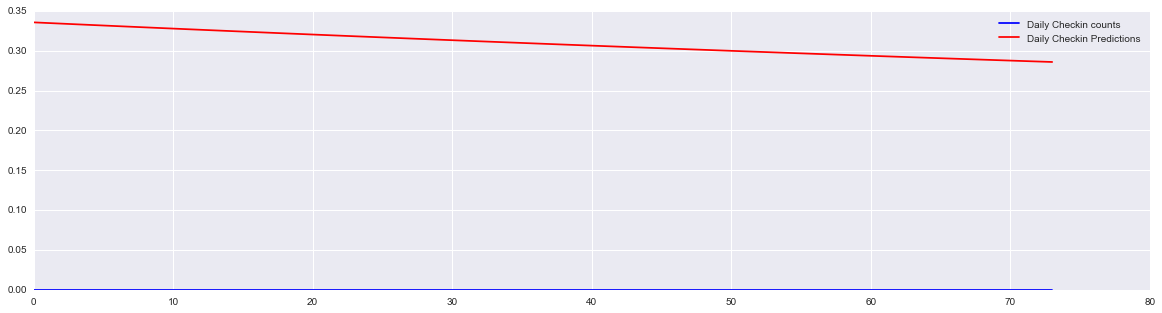

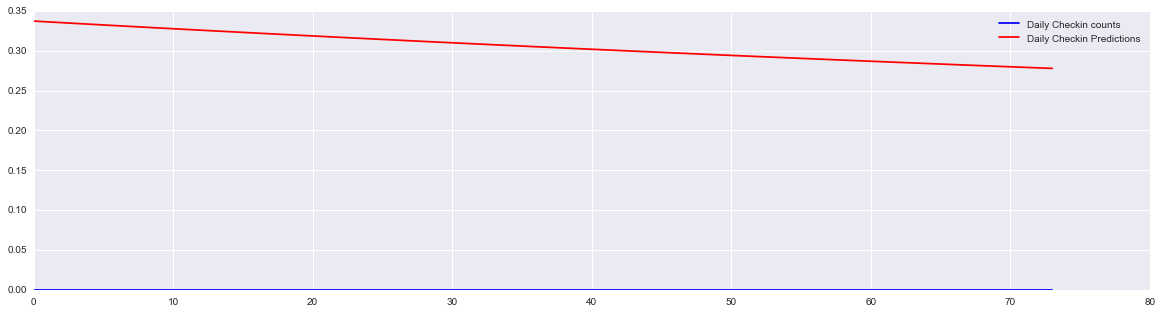

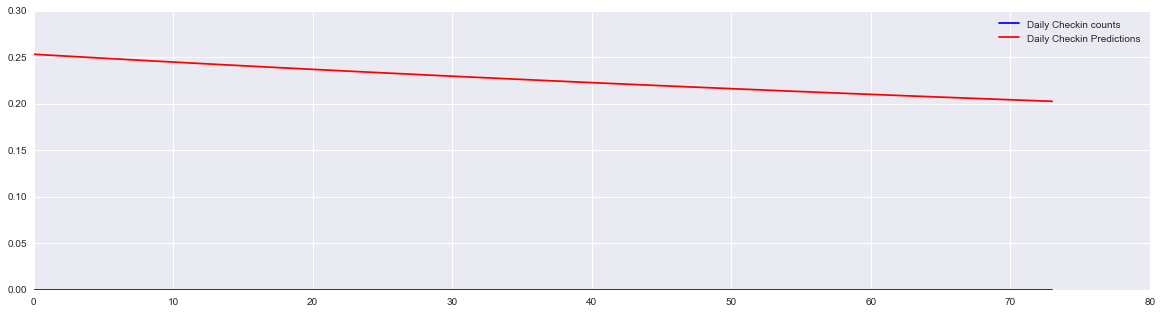

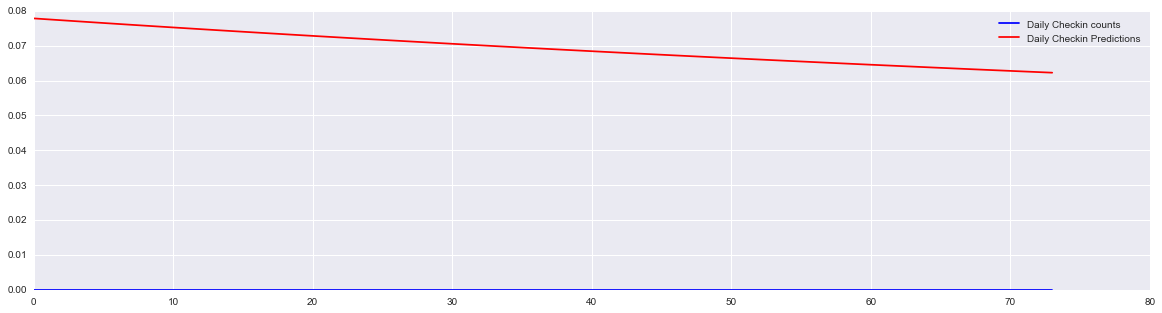

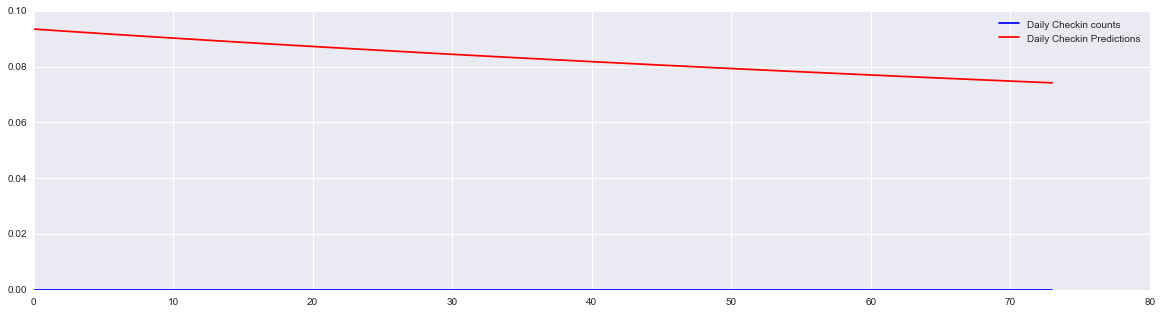

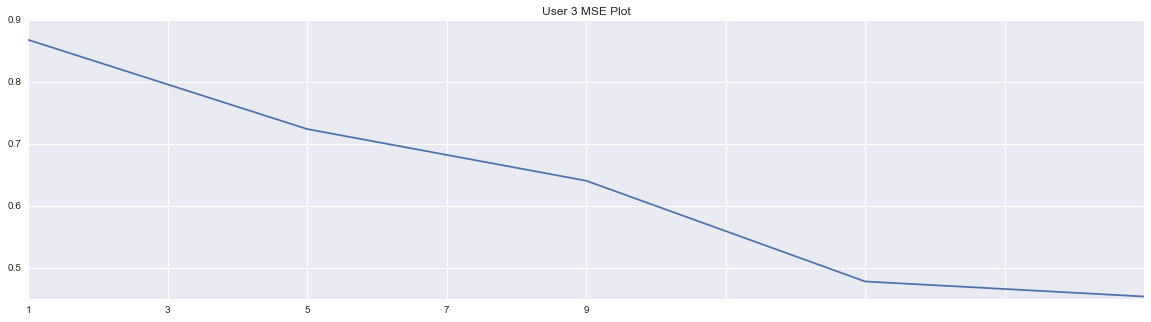

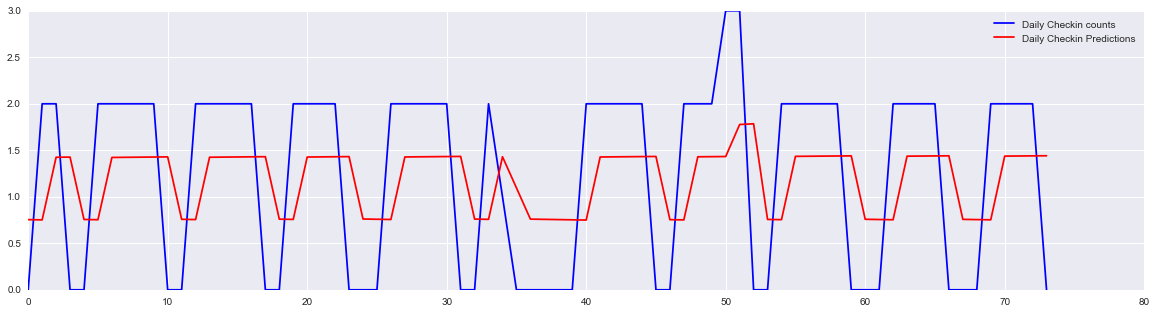

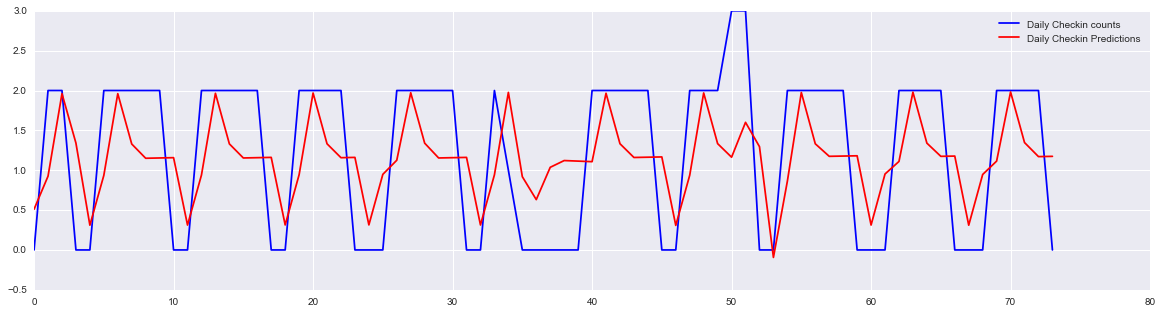

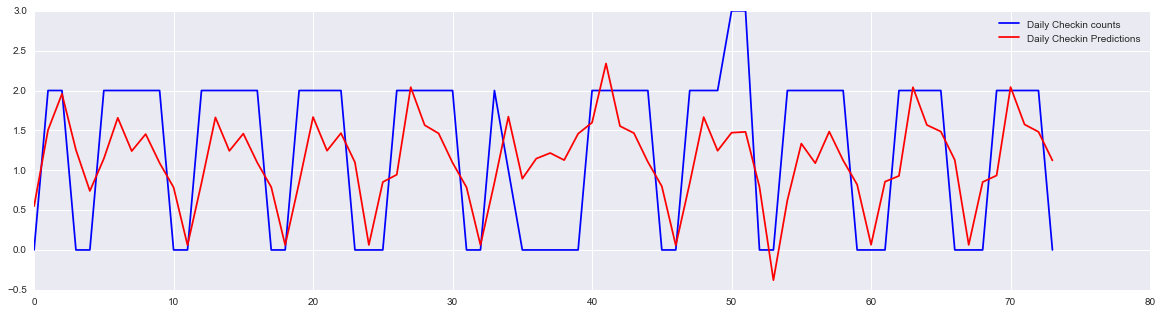

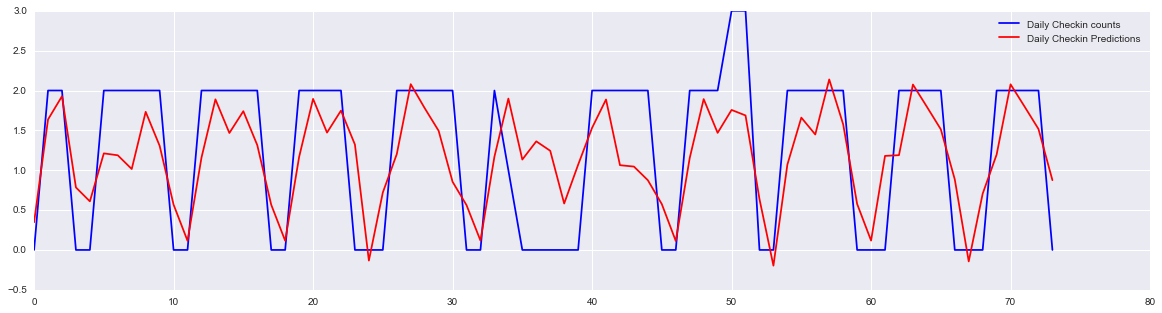

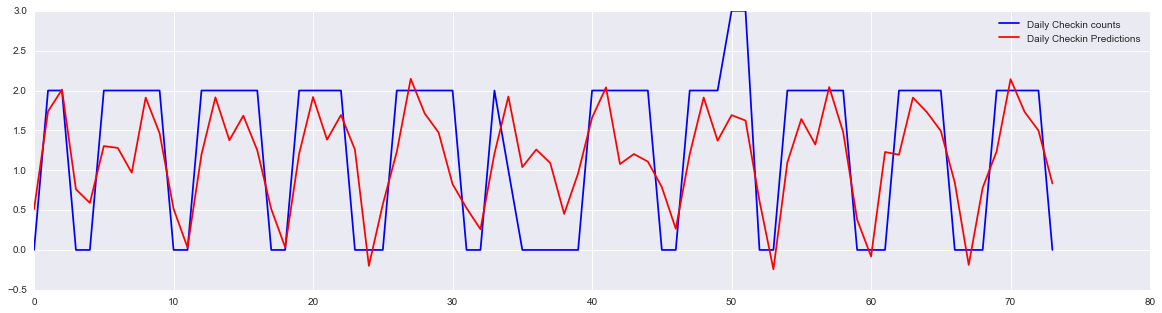

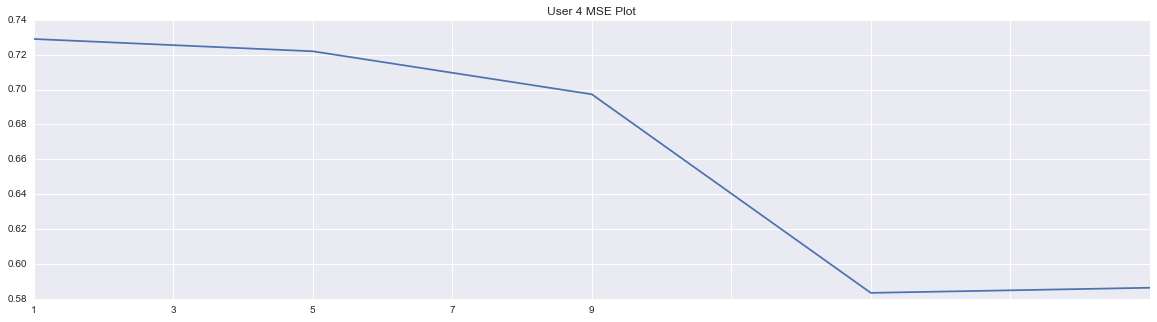

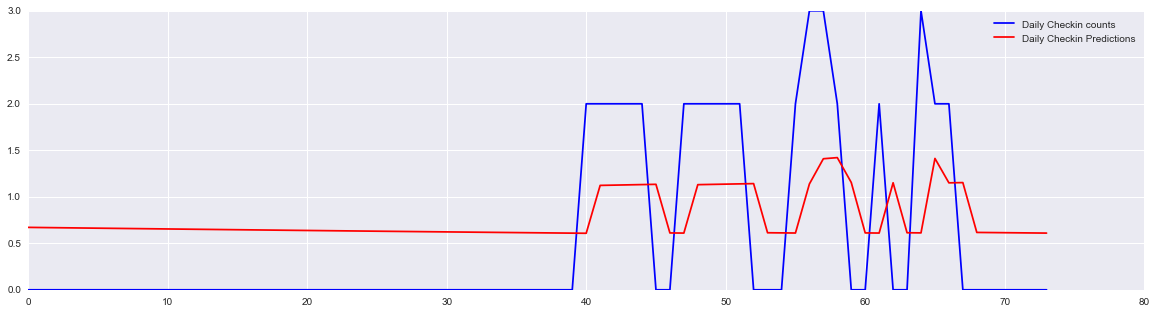

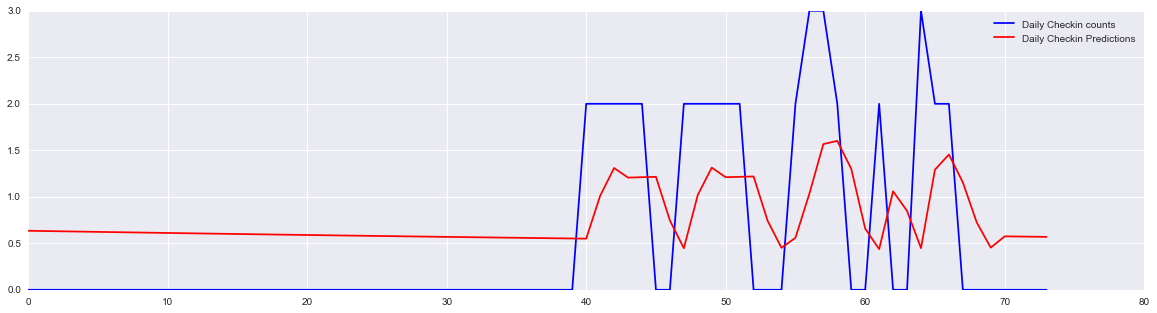

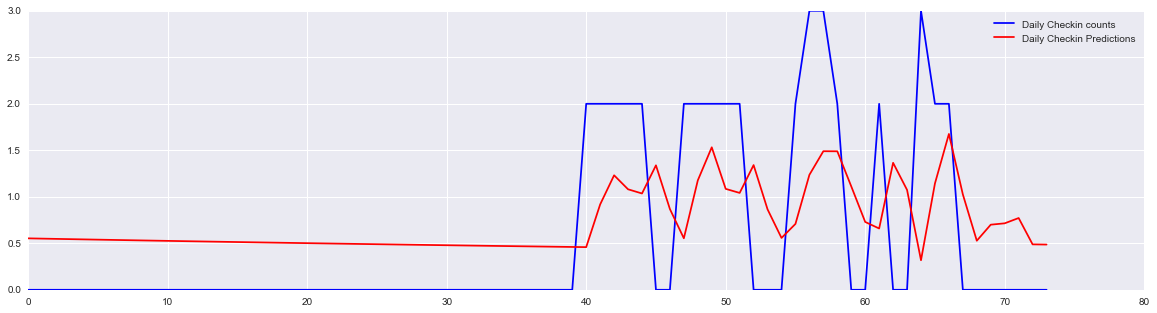

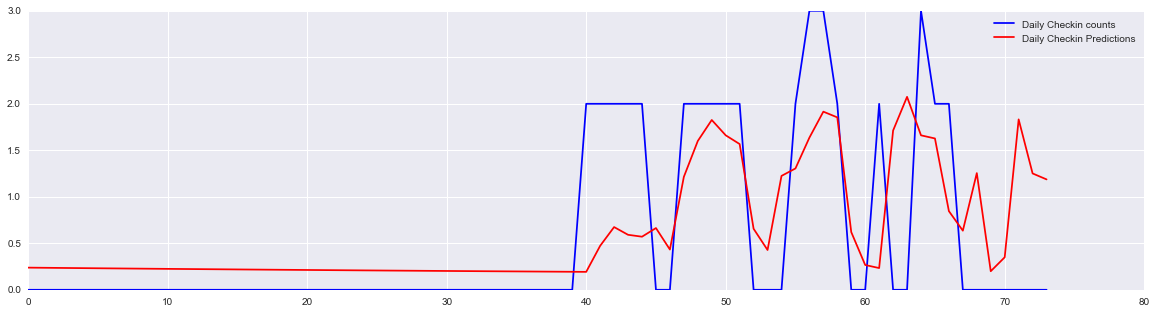

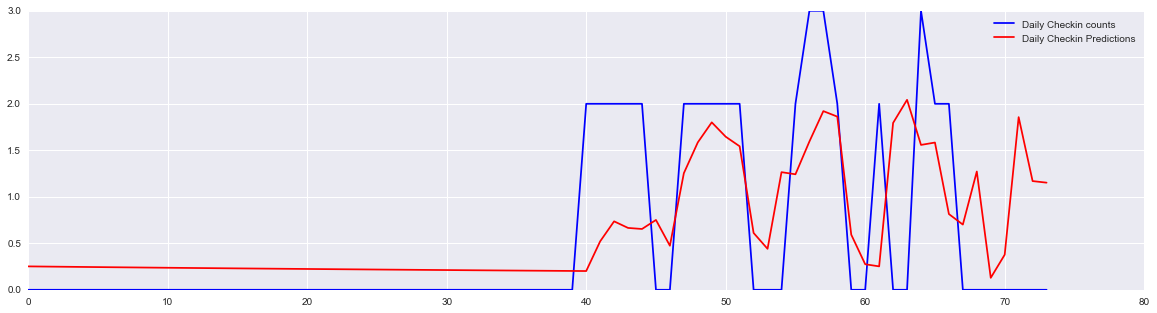

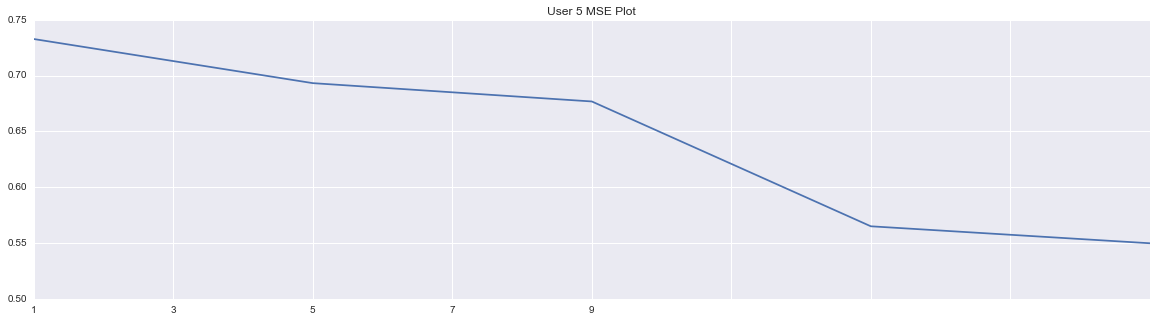

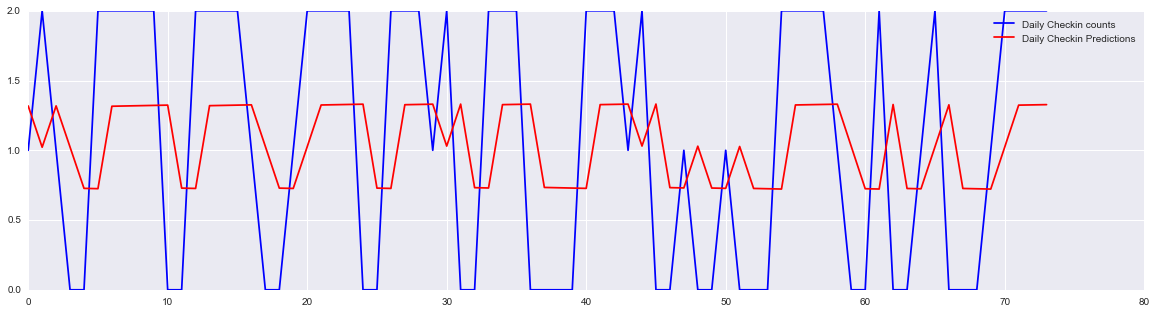

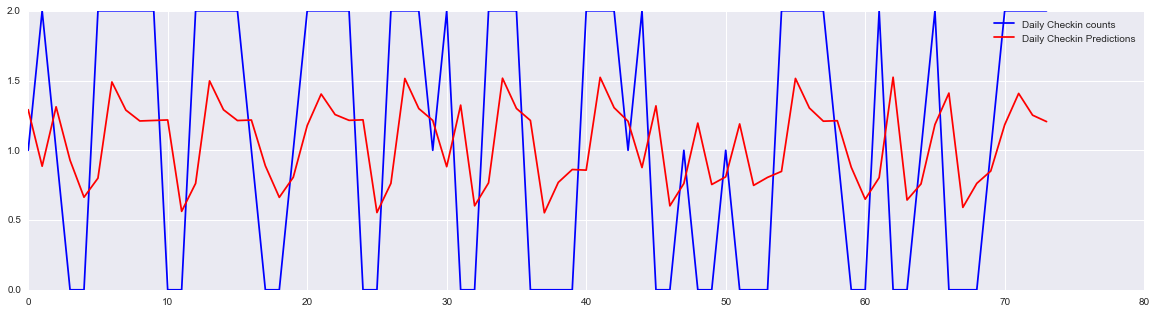

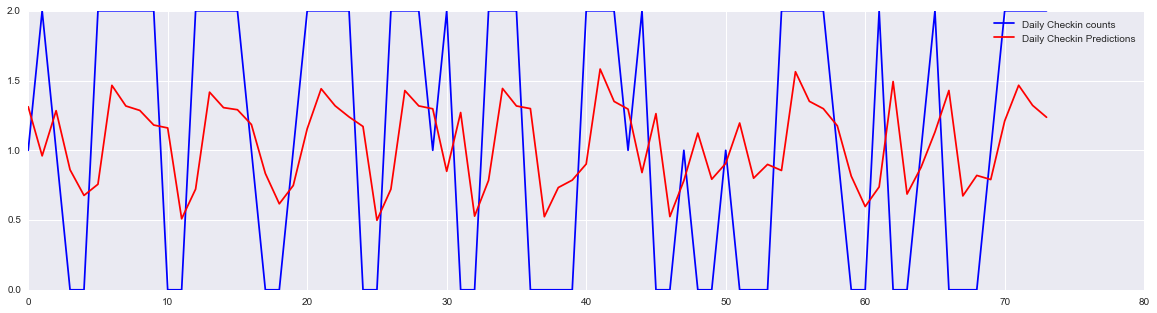

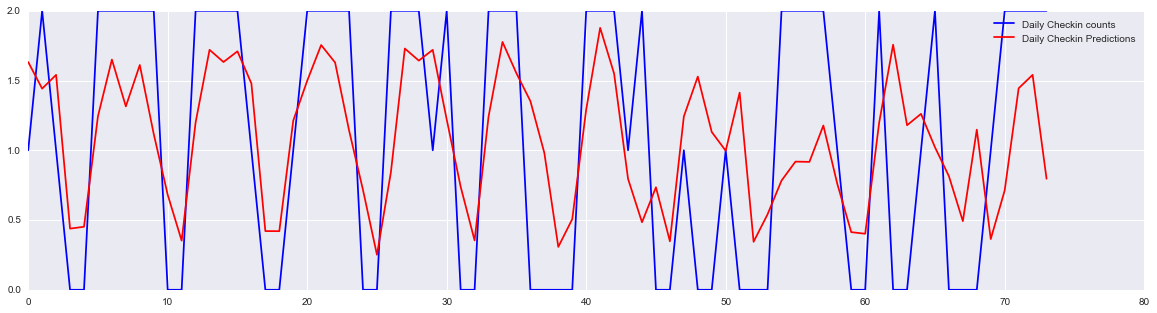

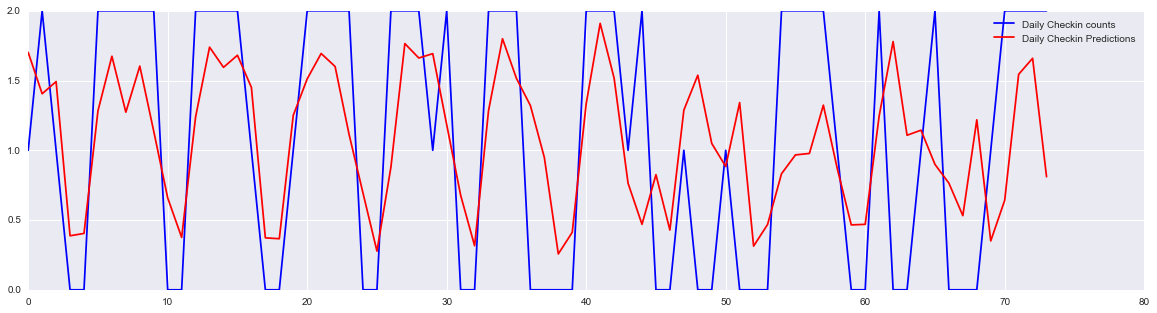

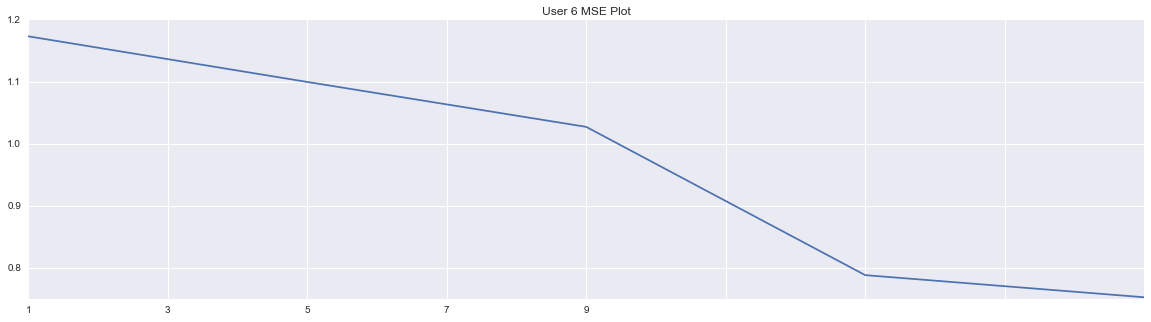

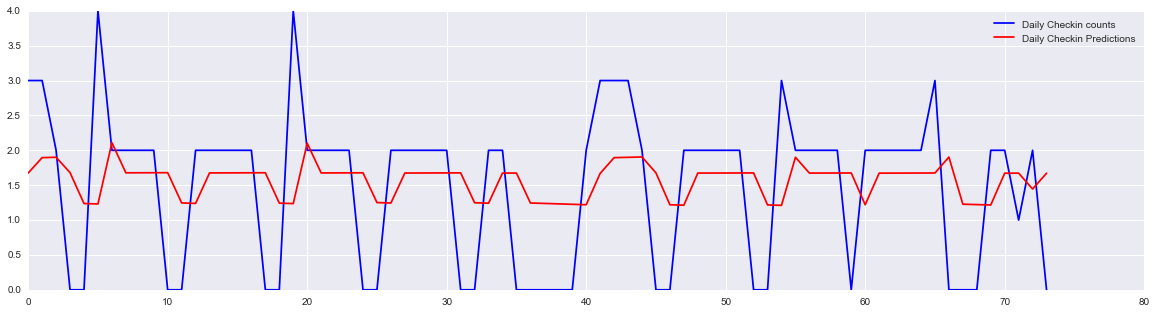

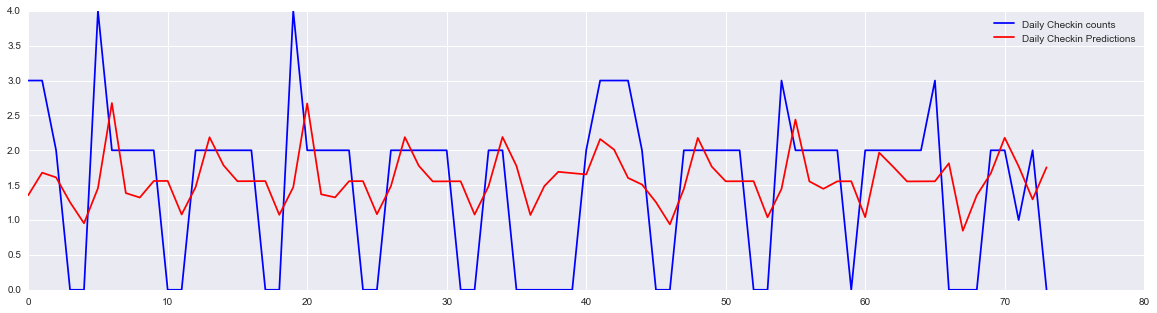

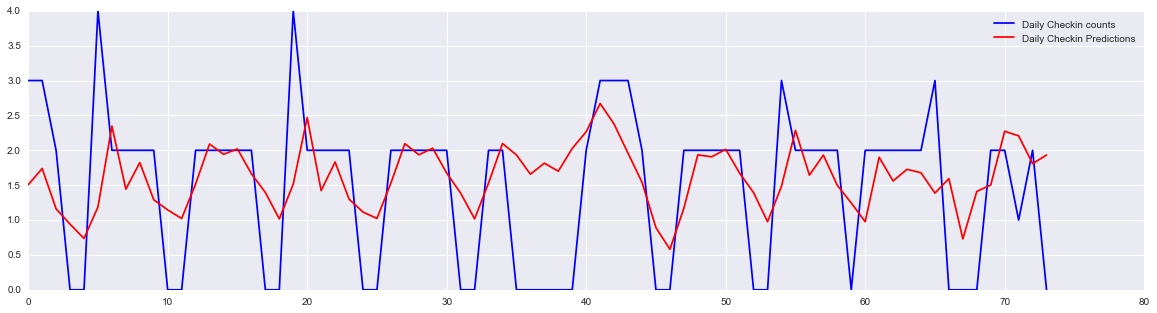

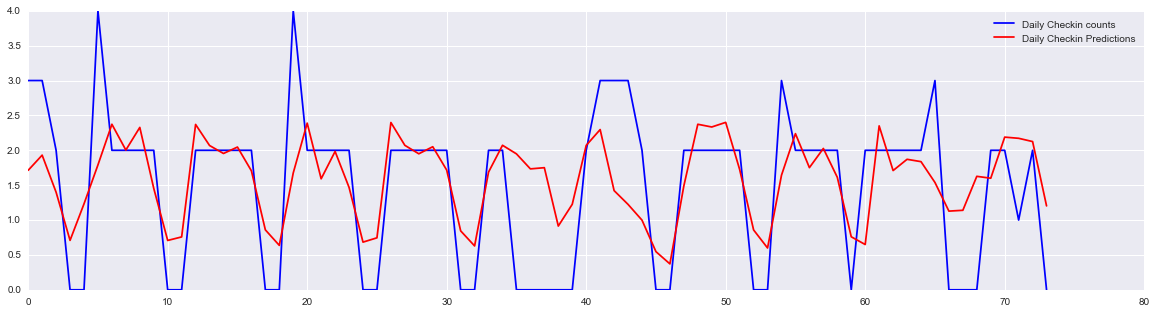

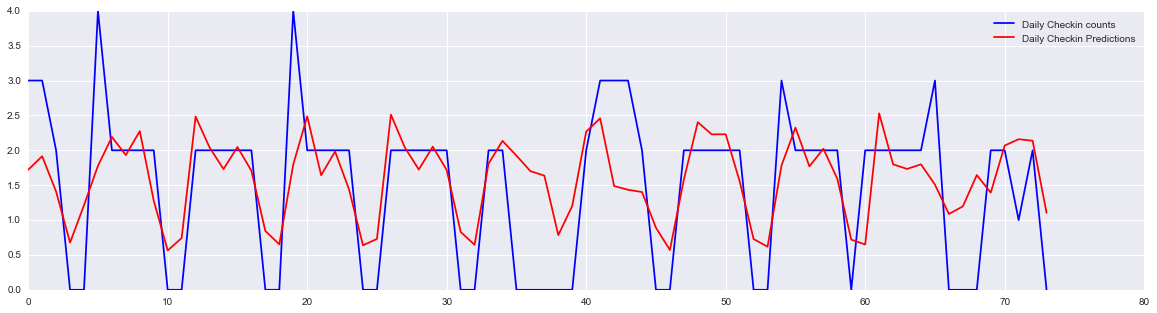

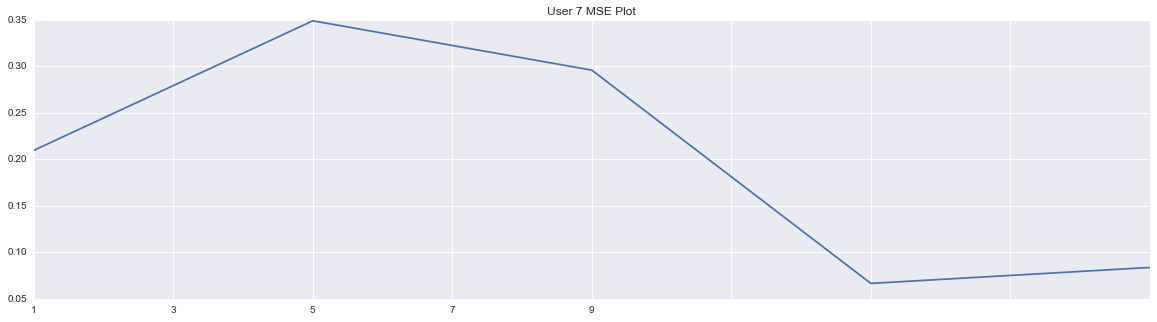

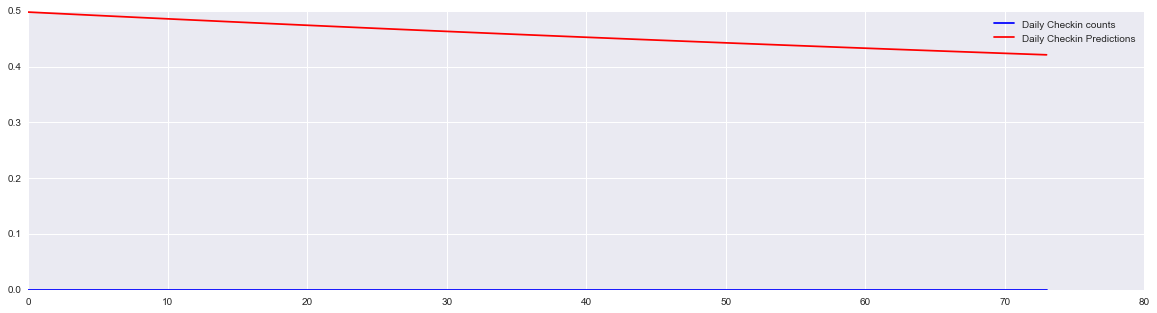

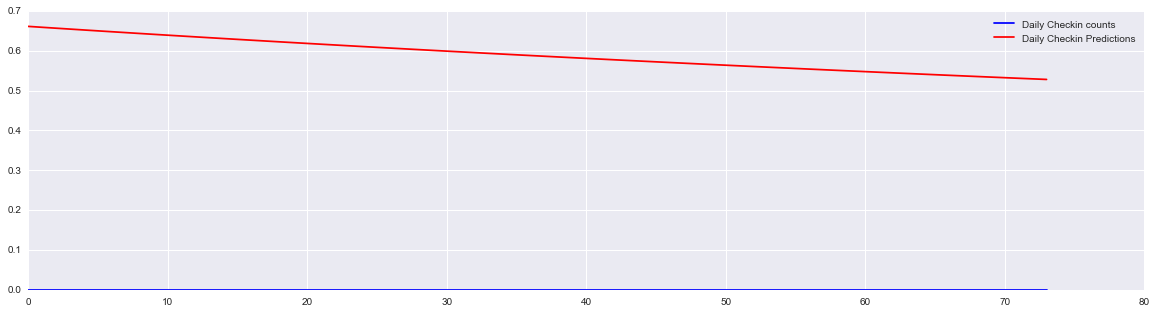

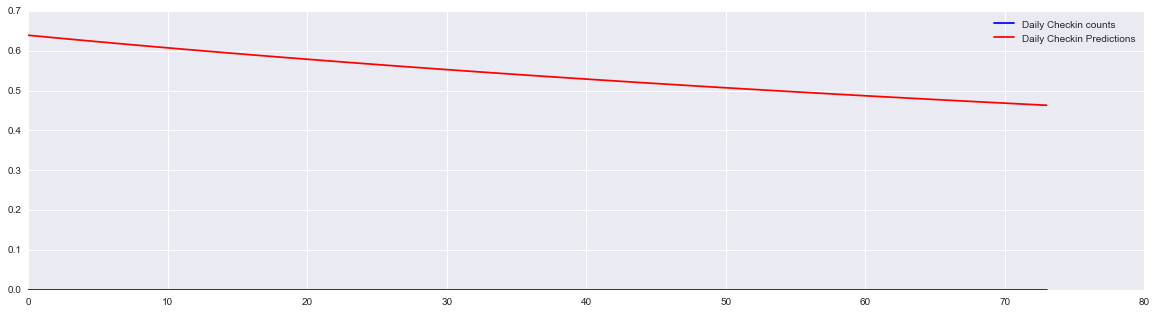

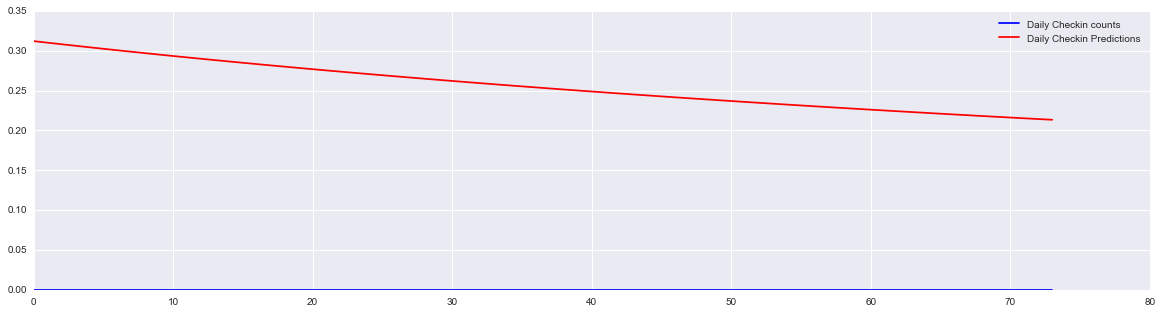

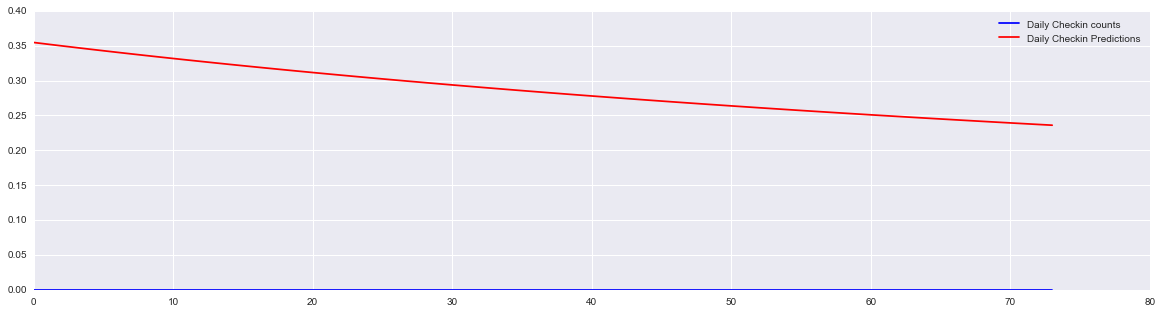

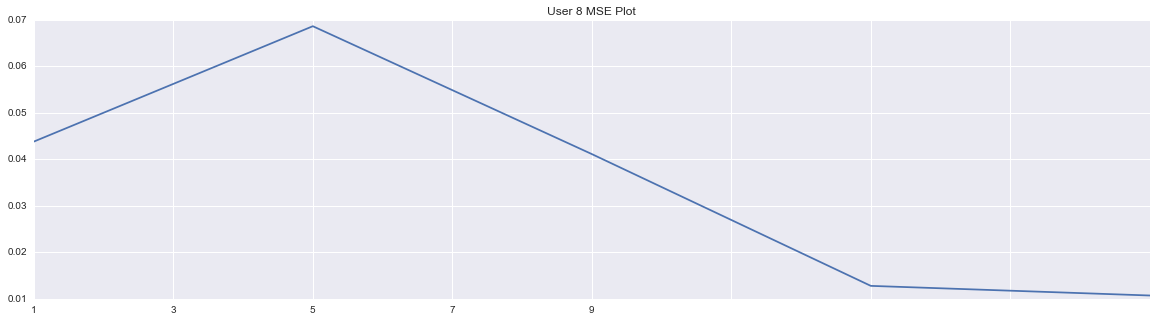

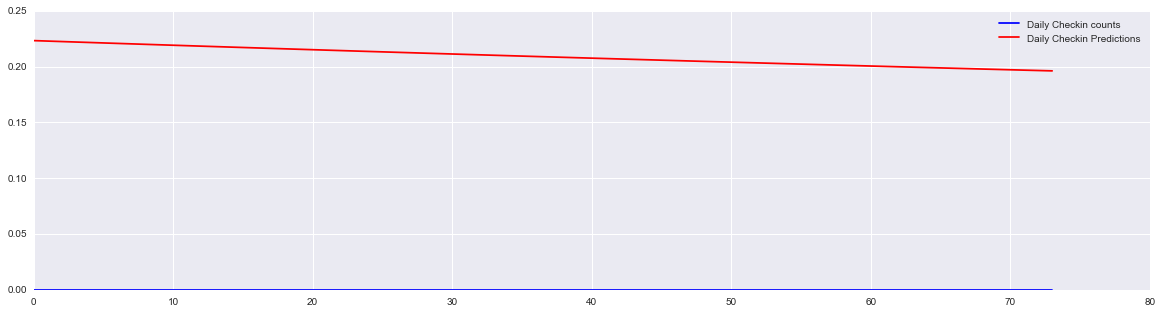

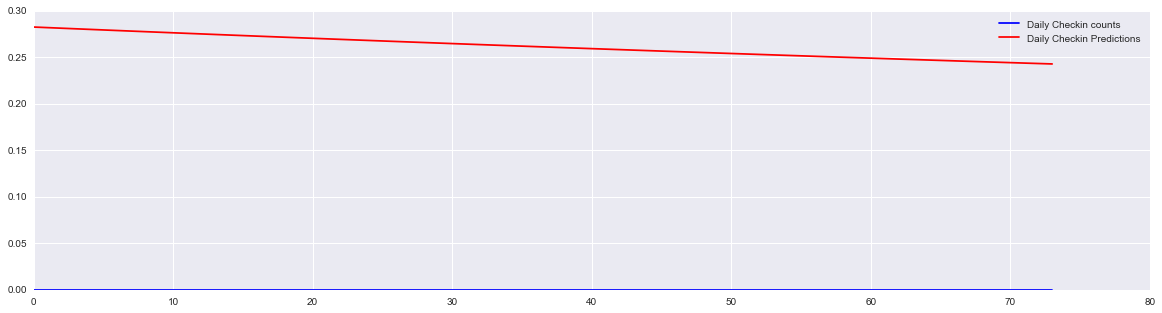

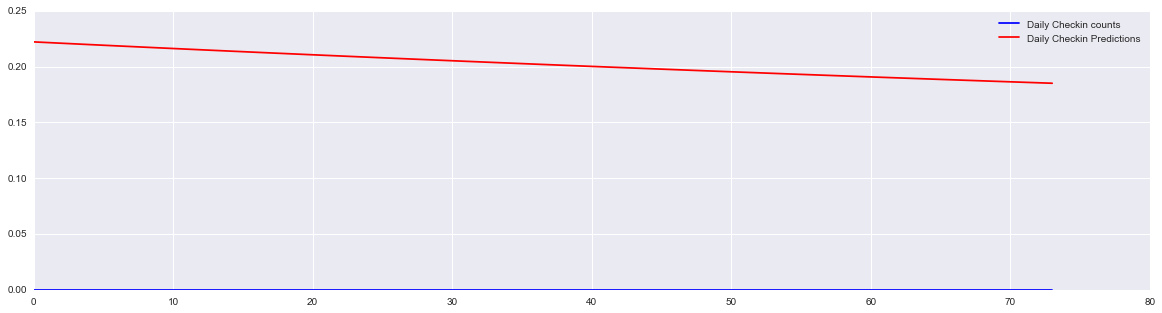

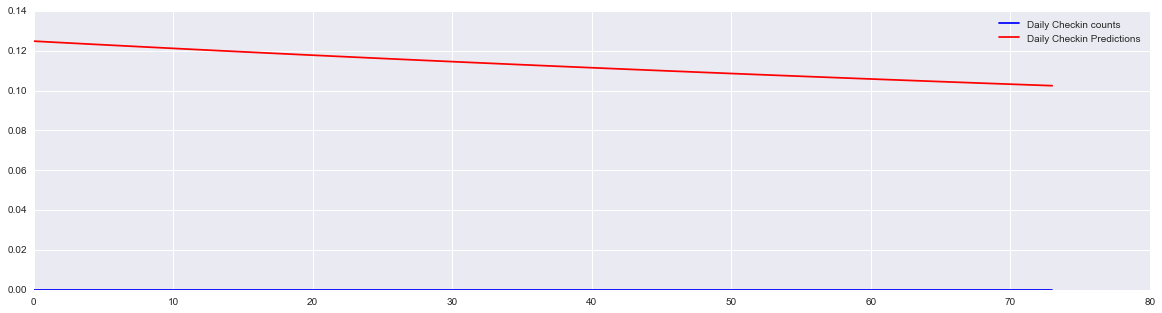

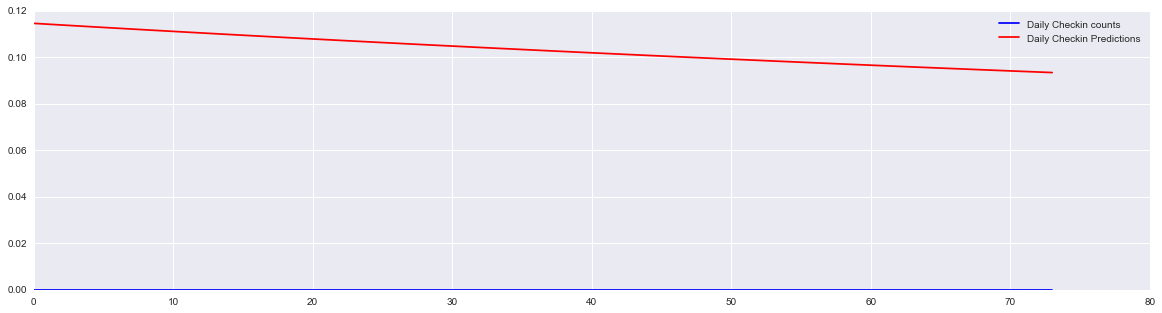

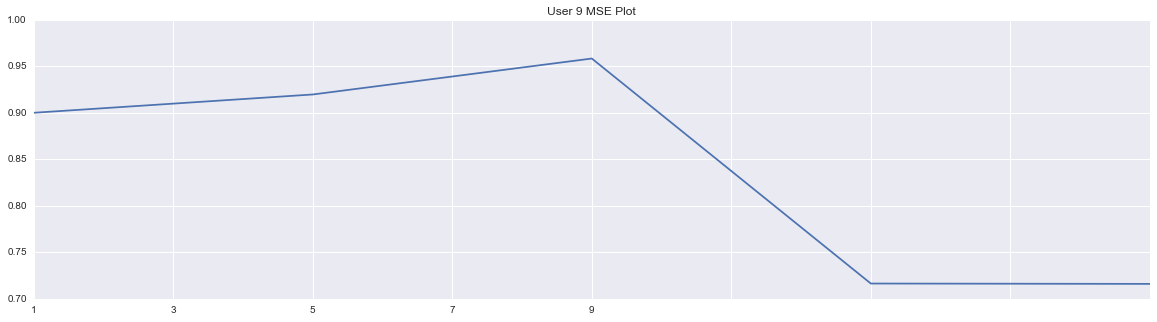

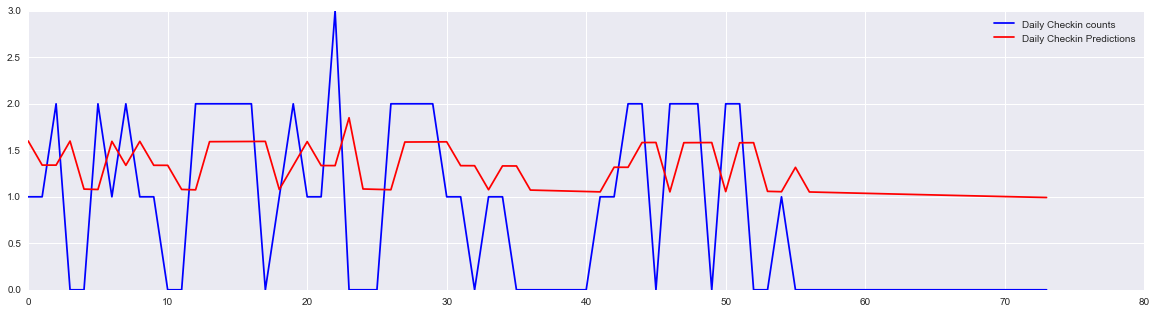

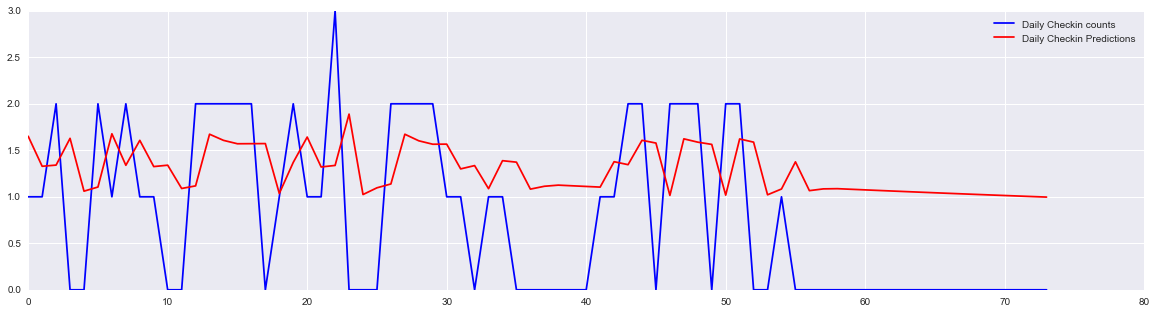

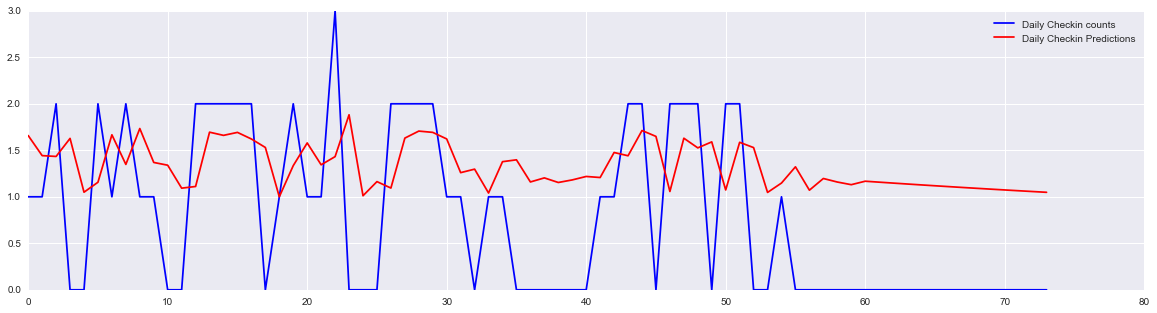

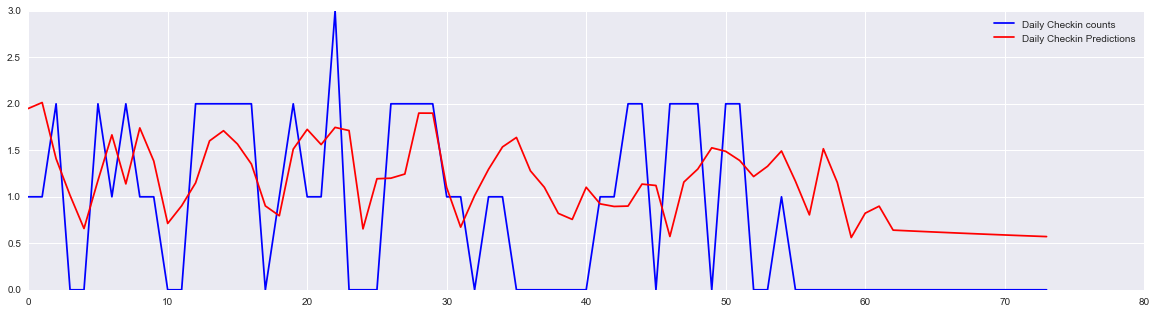

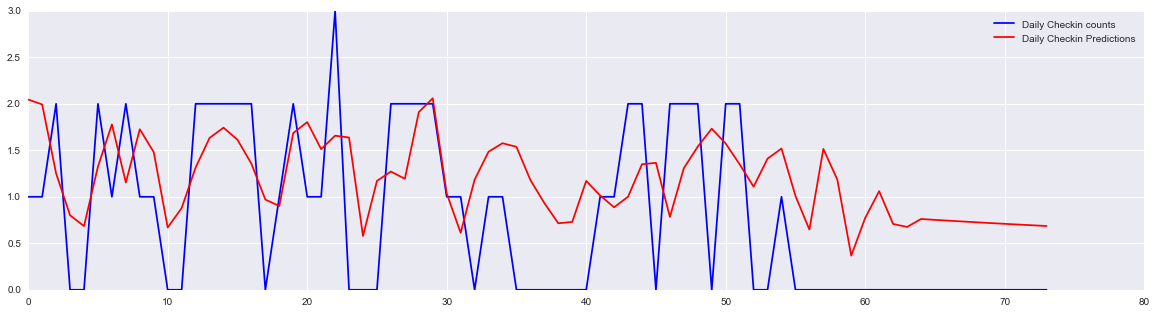

In [23]:
%%time

for j in range(10):
    msevals=list()
    fig,ax=plt.subplots(1,1,figsize=(20,5))
    mse,p,q,durbinwatson_val=test_ar(df[j],train_percentage=0.9,p=7,q=0) # p= 20 
    print("user = ",j,"p = ",i,"mse = ",mse)
    msevals.append((mse,p,q))
    ax.plot(list(map(lambda x: x[0],msevals)))
    ax.set_xticklabels(list(map(lambda x: x[1],msevals)))
    ax.set_title("User "+str(j)+" MSE Plot")
# fig,ax=plt.subplots(1,1,figsize=(10,5))
# ax.plot(list(map(lambda x: x[0],msevals)))
# ax.set_xticklabels(map(lambda x: str(x[1])+"_"+str(x[2]),msevals))

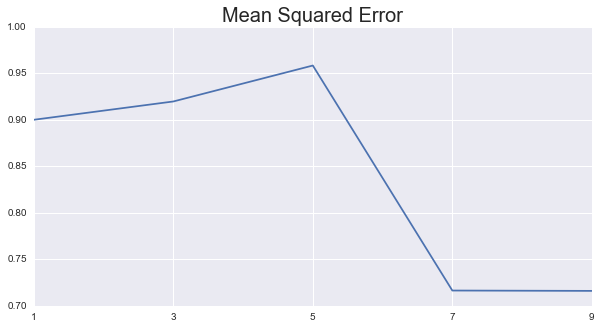

In [25]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(list(map(lambda x: x[0],msevals)))
tks=list(map(lambda x: x[1],msevals))
ax.set_xticks(range(len(tks)))
_=ax.set_xticklabels(list(map(lambda x: x[1],msevals)))
ax.set_title("Mean Squared Error",fontsize=20)

In [26]:
msevals

[(0.90002978904477571, 1, 0),
 (0.91970559300702748, 3, 0),
 (0.95836197612905472, 5, 0),
 (0.71641449692030124, 7, 0),
 (0.71603261259853723, 9, 0)]

# Point Process  (Hawkes Process)

# Dynamic Time Warping User Conditional Intensities

In [ ]:
#From http://alexminnaar.com/time-series-classification-and-clustering-with-python.html

In [317]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids

In [309]:
a=np.genfromtxt("/Users/nikhil/phd/urban_computing/datasets/wmata/wmata_2015_2016/temp.txt",delimiter=',')

In [320]:
inp_data=df.head(50).as_matrix()
print(type(inp_data))
centroids=k_means_clust(inp_data,4,10,4)

<class 'numpy.ndarray'>


TypeError: Population must be a sequence or set.  For dicts, use list(d).

In [339]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
z = np.array([[1,0], [2,2], [3,3], [4,4], [5,5]])

step=100
for i in range(5):
    for j in range(0,500,step):
        distance, path = fastdtw(df[0][j:j+step], df[i][j:j+step], dist=euclidean)
        print('0',i,distance)

0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 0 0.0
0 1 55.0
0 1 49.0
0 1 78.0
0 1 55.0
0 1 96.0
0 2 59.0
0 2 41.0
0 2 75.0
0 2 63.0
0 2 62.0
0 3 54.0
0 3 66.0
0 3 53.0
0 3 40.0
0 3 75.0
0 4 41.0
0 4 55.0
0 4 56.0
0 4 40.0
0 4 63.0


475.0
